In [67]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

import jacobian_CSTR as jac

### Functions

In [68]:
def get_Qr(T):
    return (q*Cp + hA)*T - q*Cp*Tf - hA*Tcf


def get_Qg(T):
    return (deltaH_neg*v*q*Cf*k0*math.exp(-E/(R*T)))/(q + v*k0 *
                                                      math.exp(-E/(R*T)))


def get_f(T):
    return get_Qg(T) - get_Qr(T)


def get_C(T):
    return q*Cf/(q + v*k0*math.exp(-E/(R*T)))


def get_df(T):
    return deltaH_neg*v*(q**2) *\
        Cf*k0*E*math.exp(E/(R*T)) / \
        ((T**2)*((q*math.exp(E/(R*T)) + v*k0)**2)) - q*Cp - hA


def get_newT(T, C, Tcf):
    return (deltaH_neg*v*k0*C*math.exp(-E/(R*T)) + hA*Tcf
            + q*Cp*Tf)/(q*Cp + hA)


def get_Tcf(q, T):
    return T + v*(q*Cp*(T - Tf)/hA - deltaH_neg *
                  k0*q*Cf/(q + k0*math.exp(-E/(R*T)))*math.exp(-E/(R*T))/hA)


def set_SR(tolerance, T0):
    error = 1
    C = []
    T = [T0]
    i = 0
    while error > tolerance and i <= 10000:
        C.append(get_C(T[i]))
        T.append(get_newT(T[i], C[i], Tcf))
        error = abs((T[i+1]-T[i])/T[i])
        i += 1
    return T[-1], C[-1]


def set_NR(tolerance, T0):
    error = 1
    C = []
    T = [T0]
    i = 0
    while error > tolerance and i <= 10000:
        f = get_f(T[i])
        df = get_df(T[i])
        C.append(get_C(T[i]))
        T.append(T[i] - f/df)
        error = abs((T[i+1]-T[i])/T[i])
        i += 1
    return T[-1], C[-1]


### Parâmetros

In [69]:
q: float = 0.1
v: float = 0.1
k0: float = 9703*3600
deltaH_neg: float = 5960
E: float = 11843
Cp: float = 500
hA: float = 15
R: float = 1.987
Tcf: float = 298.5
Tf: float = 298.15
Cf: float = 10

# Número 1

### Letra A

In [70]:
T_estacionario = []
C_estacionario = []

tolerance = 10**-25

Tee, Cee = set_NR(tolerance, 312)
T_estacionario.append(Tee)
C_estacionario.append(Cee)

Tee, Cee = set_SR(tolerance, 337)
T_estacionario.append(Tee)
C_estacionario.append(Cee)

Tee, Cee = set_SR(tolerance, 367)
T_estacionario.append(Tee)
C_estacionario.append(Cee)

In [71]:
def CSTR(S, t):
    C, T = S
    dCdt = q * Cf / v - C * (k0 * math.exp(-E / (R * T)) + q / v)
    dTdt = q * Tf / v + deltaH_neg * k0 * C * \
        math.exp(-E / (R * T)) / Cp + hA * Tcf / \
        (v * Cp) - T * (q / v + hA / (v * Cp))
    return [dCdt, dTdt]


def plot_CSTR_trajetories(t, T0, C0, line_type='k-', label=None):
    S0 = [C0, T0]
    sol = odeint(CSTR, S0, t)

    C_plot = sol[:, 0]
    T_plot = sol[:, 1]

    plt.plot(C_plot, T_plot, line_type, lw=1, label=label)


def plot_CSTR_separatrix(t, inf, Tee0, Cee0):
    T0 = Tee0 + inf
    C0 = Cee0
    plot_CSTR_trajetories(t, T0, C0, 'k--', 'Separatriz')

    T0 = Tee0 - inf
    C0 = Cee0
    plot_CSTR_trajetories(t, T0, C0, 'k--', 'Separatriz')


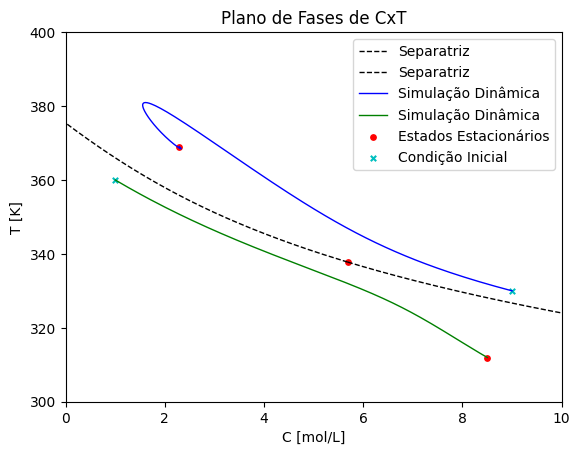

In [72]:
t = np.linspace(0, -10, 1000)
inf = 0.01
plot_CSTR_separatrix(t, inf, T_estacionario[0], C_estacionario[0])

t = np.linspace(0, 20, 1000)
T_initial = [330, 360]
C_initial = [9, 1]

plot_CSTR_trajetories(t, T_initial[0], C_initial[0], 'b-', 'Simulação Dinâmica')

plot_CSTR_trajetories(t, T_initial[1], C_initial[1], 'g-', 'Simulação Dinâmica')

plt.scatter(C_estacionario, T_estacionario, color='r',
            s=15, label='Estados Estacionários')
plt.scatter(C_initial, T_initial, color='c', s=15,
            marker='x', label='Condição Inicial')  # type: ignore

plt.legend()
plt.ylim(300, 400)
plt.xlim(0, 10)
plt.xlabel('C [mol/L]')
plt.ylabel('T [K]')
plt.title('Plano de Fases de CxT')
plt.show()

### Letra B

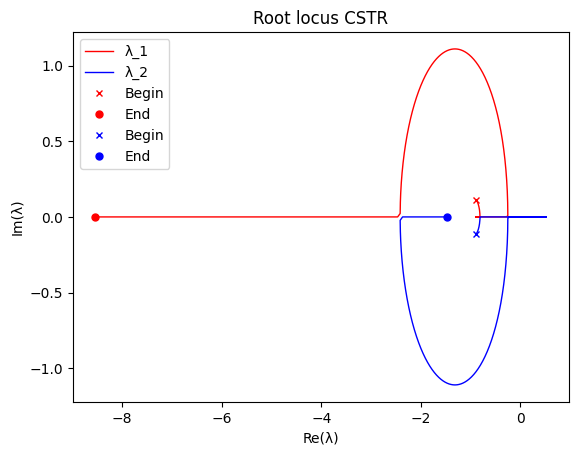

In [73]:
n = 10000
Tee_vector = np.linspace(300, 400, n)
Tcf_vector = []
Real_1 = np.ones(n)
Imag_1 = np.ones(n)
Real_2 = np.ones(n)
Imag_2 = np.ones(n)
J = []

for j, temperature in enumerate(Tee_vector):
    CEE = get_C(temperature)
    Tcf_vector.append(get_Tcf(q,temperature))

    J = jac.jacobian(CEE, temperature, q, v, k0, deltaH_neg, E, Cp, hA, R)

    eig_val = np.linalg.eig(J)[0]

    Real_1[j] = np.real(eig_val[0])
    Imag_1[j] = np.imag(eig_val[0])

    Real_2[j] = np.real(eig_val[1])
    Imag_2[j] = np.imag(eig_val[1])

plt.plot(Real_1, Imag_1, 'r-', Real_2, Imag_2, 'b-', linewidth=1)
plt.title('Root locus CSTR')
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.plot(Real_1[0], Imag_1[0], 'rx', Real_1[n-1],
         Imag_1[n-1], 'ro', linewidth=1, markersize=5)
plt.plot(Real_2[0], Imag_2[0], 'bx', Real_2[n-1],
         Imag_2[n-1], 'bo', linewidth=1, markersize=5)
plt.legend(['λ_1', 'λ_2', 'Begin', 'End', 'Begin', 'End'])
plt.show()


### Letra C

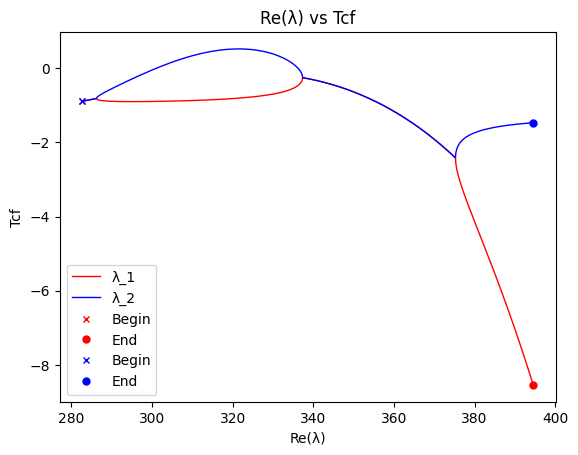

In [74]:
plt.plot(Tcf_vector, Real_1, 'r-', Tcf_vector, Real_2, 'b-', linewidth=1)
plt.title('Re(λ) vs Tcf')
plt.xlabel('Re(λ)')
plt.ylabel('Tcf')
plt.plot(Tcf_vector[0], Real_1[0], 'rx',
         Tcf_vector[n-1], Real_1[n-1], 'ro', linewidth=1, markersize=5)
plt.plot(Tcf_vector[0], Real_2[0], 'bx',
         Tcf_vector[n-1], Real_2[n-1], 'bo', linewidth=1, markersize=5)
plt.legend(['λ_1', 'λ_2', 'Begin', 'End', 'Begin', 'End'])
plt.show()

# Número 4

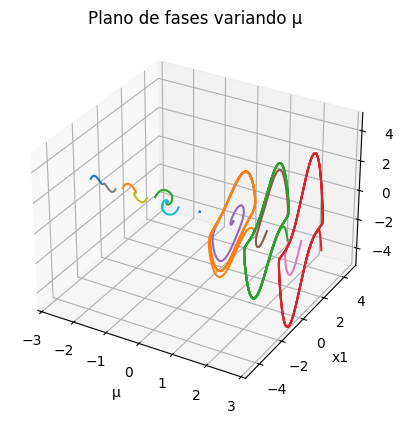

In [75]:
def VdP(X, t):
    x1, x2 = X
    dx1_dt = x2
    dx2_dt = mi*(1 - x1**2)*x2 - x1
    return [dx1_dt, dx2_dt]


def plot_trajetories_VdP(X0_1, X0_2, t, mi):
    mi = mi
    if mi < 0:
        sol = odeint(VdP, X0_1, t)
        x1_plot = sol[:, 0]
        x2_plot = sol[:, 1]
    elif mi == 0:
        X0 = [0.001, 0]
        sol = odeint(VdP, X0, t)
        x1_plot = sol[:, 0]
        x2_plot = sol[:, 1]
    else:
        sol = odeint(VdP, X0_2, t)
        x1_plot = sol[:, 0]
        x2_plot = sol[:, 1]
    return x1_plot, x2_plot


mi_values = [-3, -2, -1, 0, 1, 2, 3]
t = np.linspace(0, 20, 1000)
X0_1 = [-1, 1]
X0_2 = [0.001, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for mi in mi_values:
    x1_plot, x2_plot = plot_trajetories_VdP(X0_1, X0_2, t, mi)

    ax.plot(mi * np.ones(len(x1_plot)), x1_plot, x2_plot)

X0_1 = [1, -1]
X0_2 = [2, -2]

for mi in mi_values:
    x1_plot, x2_plot = plot_trajetories_VdP(X0_1, X0_2, t, mi)

    ax.plot(mi * np.ones(len(x1_plot)), x1_plot, x2_plot)

ax.set_xlabel('μ')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.set_title('Plano de fases variando μ')
ax.set_xlim(-3, 3)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)
plt.show()
    


# Número 5

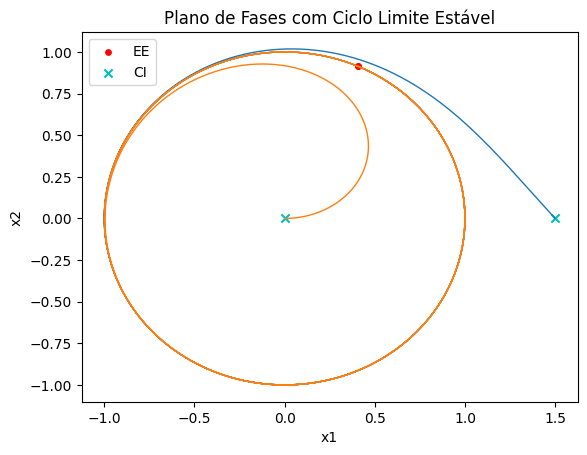

In [76]:
def Stable_Orbit(P, t):
    ro, teta = P
    dro_dt = 1 - ro**2
    dteta_dt = 1
    return [dro_dt, dteta_dt]


def limit_cicle_stable(P0, t):
    X0 = [P0[0]*np.cos(P0[1]), P0[0]*np.sin(P0[1])]
    sol = odeint(Stable_Orbit, P0, t)

    ro_plot = sol[:, 0]
    teta_plot = sol[:, 1]
    x1 = []
    x2 = []

    for i in range(len(ro_plot)):
        x1.append(ro_plot[i]*np.cos(teta_plot[i]))
        x2.append(ro_plot[i]*np.sin(teta_plot[i]))

    plt.plot(x1, x2, lw=1)
    return x1[-1], x2[-1], X0


x1_points = []
x2_points = []
x0_points_x1 = []
x0_points_x2 = []

t = np.linspace(0, 20, 1000)
P0 = [1.5, 0]
x1_value, x2_value, x0_value = limit_cicle_stable(P0, t)
x1_points.append(x1_value)
x2_points.append(x2_value)
x0_points_x1.append(x0_value[0])
x0_points_x2.append(x0_value[1])

P0 = [0, 0]
x1_value, x2_value, x0_value = limit_cicle_stable(P0, t)
x1_points.append(x1_value)
x2_points.append(x2_value)
x0_points_x1.append(x0_value[0])
x0_points_x2.append(x0_value[1])

plt.scatter(x1_points, x2_points, color='r', s=15, label='EE')
plt.scatter(x0_points_x1, x0_points_x2, color='c', s=35,
            marker='x', label='CI')  # type: ignore
plt.title('Plano de Fases com Ciclo Limite Estável')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()


# Número 6

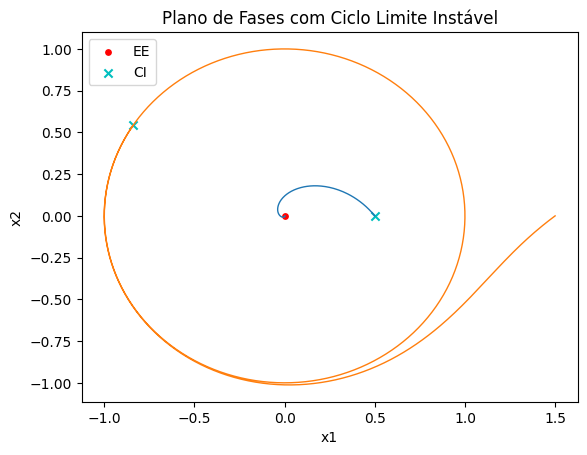

In [77]:
def Unstable_Orbit(P, t):
    ro, teta = P
    dro_dt = ro*(ro**2 - 1)
    dteta_dt = 1
    return [dro_dt, dteta_dt]


def limit_cicle_unstable(P0, t):
    X0 = [P0[0]*np.cos(P0[1]), P0[0]*np.sin(P0[1])]
    sol = odeint(Unstable_Orbit, P0, t)

    ro_plot = sol[:, 0]
    teta_plot = sol[:, 1]
    x1 = []
    x2 = []

    for i in range(len(ro_plot)):
        x1.append(ro_plot[i]*np.cos(teta_plot[i]))
        x2.append(ro_plot[i]*np.sin(teta_plot[i]))

    plt.plot(x1, x2, lw=1)
    return x1[-1], x2[-1], X0


x1_points = []
x2_points = []
x0_points_x1 = []
x0_points_x2 = []

t = np.linspace(0, 20, 1000)
P0 = [0.5, 0]
x1_value, x2_value, x0_value = limit_cicle_unstable(P0, t)
x1_points.append(x1_value)
x2_points.append(x2_value)
x0_points_x1.append(x0_value[0])
x0_points_x2.append(x0_value[1])

t = np.linspace(0, -10, 1000)
P0 = [1.5, 0]
x1_value, x2_value, x0_value = limit_cicle_unstable(P0, t)
# x1_points.append(x1_value)
# x2_points.append(x2_value)
x0_points_x1.append(x1_value)
x0_points_x2.append(x2_value)

plt.scatter(x1_points, x2_points, color='r', s=15, label='EE')
plt.scatter(x0_points_x1, x0_points_x2, color='c', s=35,
            marker='x', label='CI')  # type: ignore
plt.title('Plano de Fases com Ciclo Limite Instável')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()


# Número 7

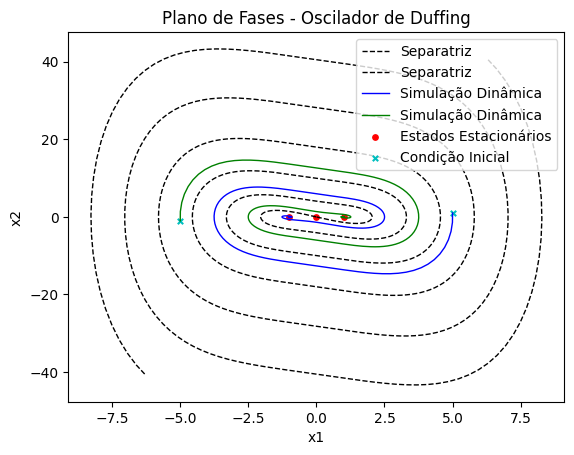

In [78]:
def Duffing(X, t):
    x1, x2 = X
    dx1_dt = x2
    dx2_dt = - x2 + x1 - x1**3
    return [dx1_dt, dx2_dt]


def plot_Duffing_trajetories(t, x1_init, x2_init, line_type='k-', label=None):
    X0 = [x1_init, x2_init]
    sol = odeint(Duffing, X0, t)

    x1_plot = sol[:, 0]
    x2_plot = sol[:, 1]

    plt.plot(x1_plot, x2_plot, line_type, lw=1, label=label)


def plot_Duffing_separatrix(t, inf, x1ee0, x2ee0):
    x1_init = x1ee0 + inf
    x2_init = x2ee0
    plot_Duffing_trajetories(t, x1_init, x2_init, 'k--', 'Separatriz')

    x1_init = x1ee0 - inf
    x2_init = x2ee0
    plot_Duffing_trajetories(t, x1_init, x2_init, 'k--', 'Separatriz')


t = np.linspace(0, -9, 1000)
inf = 0.01
plot_Duffing_separatrix(t, inf, 0, 0)

t = np.linspace(0, 20, 1000)
x1_initial = [5, -5]
x2_initial = [1, -1]

plot_Duffing_trajetories(
    t, x1_initial[0], x2_initial[0], 'b-', 'Simulação Dinâmica')

plot_Duffing_trajetories(
    t, x1_initial[1], x2_initial[1], 'g-', 'Simulação Dinâmica')

x1_estacionario = [0, 1, -1]
x2_estacionario = [0, 0, 0]
plt.scatter(x1_estacionario, x2_estacionario, color='r',
            s=15, label='Estados Estacionários')
plt.scatter(x1_initial, x2_initial, color='c', s=15,
            marker='x', label='Condição Inicial')  # type: ignore
plt.title('Plano de Fases - Oscilador de Duffing')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

